<a href="https://colab.research.google.com/github/ekaminuma/ROIS-DS-JOINT/blob/master/diabetes_opendata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**オープンデータ入門**
2020/1/30 神沼英里

-----
-----
##診療オープンデータを使った糖尿病自動予測

- Google Dataset Searchから、論文表データのURLを取得。
- 学習データであるオープンデータ（表データ）を取得。
- **年齢や検査値から糖尿病(Diabetes Mellitus)を予測**する**XGBoost (eXtreme Gradient Boosting)**モデルを構築する。
- 論文情報　(Supplemental Table1がデータ)　
  - Woo YC et el., "Validation of the diabetes screening tools proposed by the American Diabetes Association in an aging Chinese population", PLoS One. 2017 Sep 14;12(9):e0184840 [https://www.ncbi.nlm.nih.gov/pubmed/28910380](https://www.ncbi.nlm.nih.gov/pubmed/28910380)
------

##手順
- [1]. 論文雑誌Webサイトから表データをダウンロードでColabディスクに保存
- [2]. 表データの統計量計算（相関係数）と変数抽出
- [3]. XGBoostによる糖尿病予測、変数重要度、木構造可視化


-------------------------------------
--------------------------------------

### [1]. 表データをダウンロードでColabディスクに取得


In [0]:
#----------[1-1: PLOS ONEのサイトからデータをダウンロード]-------------------
#
# 表データのファイル形式は、EXCEL形式である事に注意。
#
#----------------------------------------------------------------------------
import urllib.request

#URLと保存パスを指定 --- （＊２）
url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0184840.s001"
savename = "tab1.xlsx"

#ダウンロード --- （＊3）
urllib.request.urlretrieve(url, savename)
print("File Saved.")

File Saved.


In [0]:
#----------[1-2:ファイルがColabディスクに保存されているか確認]-------------------
#
!ls -l

total 156
drwxr-xr-x 1 root root   4096 Feb  5 18:37 sample_data
-rw-r--r-- 1 root root 153572 Feb 14 02:35 tab1.xlsx


In [0]:
#----------[1-3:EXCELファイルを読込]-------------------
#
#  tab1.xlsxをpandasで読み込む
#
#--------------------------------------------------------------------------------
import pandas as pd

filename='tab1.xlsx'
book = pd.ExcelFile(filename) 

#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
sheet_name = book.sheet_names
 
#lenでシートの総数を確認
sheetN = len(sheet_name)
 
#シートの数とシートの名前のリストの表示
print ("Sheet の数:", sheetN)
print (sheet_name)

Sheet の数: 1
['Sheet1']


In [0]:
#----------[1-4:DataFrame変数にセット]-------------------
#
# DataFrameとして一つ目のsheetを読込
# シートの先頭10行を表示
#
#  属性変数の一部
#  [2列目] DM: 糖尿病(Diabetes Mellitus)
#  [3列目] Age: 年齢  
#   :
#  [7列目] FG : 空腹時血糖値 
#  [8列目] 2hG:ブドウ糖負荷試験の2時間後血糖値 　
#  [9列目] HbA1c : ヘモグロビンA1c 
#
#---------------------------------------------------------------
sheet_df = book.parse(sheet_name[0])
sheet_df.head(10) 

,No.,DM,Age,Gender,smoking4,Physical inactivity,FG,2hG,HbA1c (IFCC),First degree of relative with DM,History of GDM,BMI,HT,Screening criteria,Risk test
0,1,1,62,1,Never,0,5.8,11.7,45.359,1,0,24.3589,0,1,5
1,2,0,51,1,Never,1,4.3,4.9,36.615,0,1,20.9523,0,0,4
2,3,1,68,1,Never,1,8.0,18.8,55.196,1,0,25.8857,1,1,7
3,4,1,47,1,Never,0,4.5,11.3,38.801,0,0,28.141,0,1,2
4,5,0,59,1,Never,1,4.8,7.9,40.987,1,0,28.7312,0,1,5
5,6,0,62,1,Never,0,4.4,5.6,39.894,1,0,18.8916,0,0,4
6,7,0,56,1,Never,0,4.2,5.8,36.615,1,1,21.2576,0,0,4
7,8,0,48,1,Never,1,4.5,8.1,43.173,0,0,28.9811,0,1,3
8,9,0,61,1,Never,0,5.5,11.0,43.173,1,0,23.084,0,1,5
9,10,0,58,1,Never,1,4.8,4.9,32.243,1,0,23.3241,0,1,5


In [0]:
#----------[1-5:被験者数のカウント属性数]-------------------
#
# 行数、列数を表示
# 論文との被験者数が合っているか確認
#
print('data size of row,column=(%d,%d)' % (len(sheet_df),len(sheet_df.columns) ))
tmp_DM=sheet_df.iloc[:,1];
print(tmp_DM.shape)
#print(tmp_DM.count(0))

N_PAT=len([i for i in tmp_DM if i == 1]) #患者
N_CNT=len([i for i in tmp_DM if i == 0]) #対照
print('DMとCTLの被検者数=(%d,%d)' % (N_PAT, N_CNT))

#--------------------------------------------------------------------------
#論文p.3 Resultsでは、1415人中の95人が糖尿病患者と記載されている。
#1415 subjects (age: 58.1±10.2) with no diabetes at the last preceding assessment
#returned for follow up and 95 (6.7%) were diagnosed to have diabetes
#-----------------------------------------------------------------------


data size of row,column=(1415,15)
(1415,)
DMとCTLの被検者数=(95,1320)


---
---
###[2]. 表データの統計量計算（相関係数）と変数抽出

In [0]:
#--------[2-1:欠損データの確認]-----------------------------
#
#　結果から、今回データは欠損無し
#
#-----------------------------------------------------------
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns= {0 : 'Missing Values', 1: '% of total values'})
    return mis_val_table_ren_columns
 
# 欠損データの確認
missing_values_table(sheet_df)

,Missing Values,% of total values
No.,0,0.0
DM,0,0.0
Age,0,0.0
Gender,0,0.0
smoking4,0,0.0
Physical inactivity,0,0.0
FG,0,0.0
2hG,0,0.0
HbA1c (IFCC),0,0.0
First degree of relative with DM,0,0.0


                                       No.  ...  Risk test
No.                               1.000000  ...  -0.185373
DM                               -0.031055  ...   0.200373
Age                              -0.145164  ...   0.509872
Gender                           -0.019996  ...  -0.367573
Physical inactivity              -0.235695  ...   0.285137
FG                               -0.036676  ...   0.239958
2hG                              -0.031191  ...   0.292552
HbA1c (IFCC)                     -0.075652  ...   0.214339
First degree of relative with DM -0.017518  ...   0.247685
History of GDM                   -0.045258  ...   0.034364
HT                               -0.110371  ...   0.519524
Screening criteria               -0.052357  ...   0.493705
Risk test                        -0.185373  ...   1.000000

[13 rows x 13 columns]


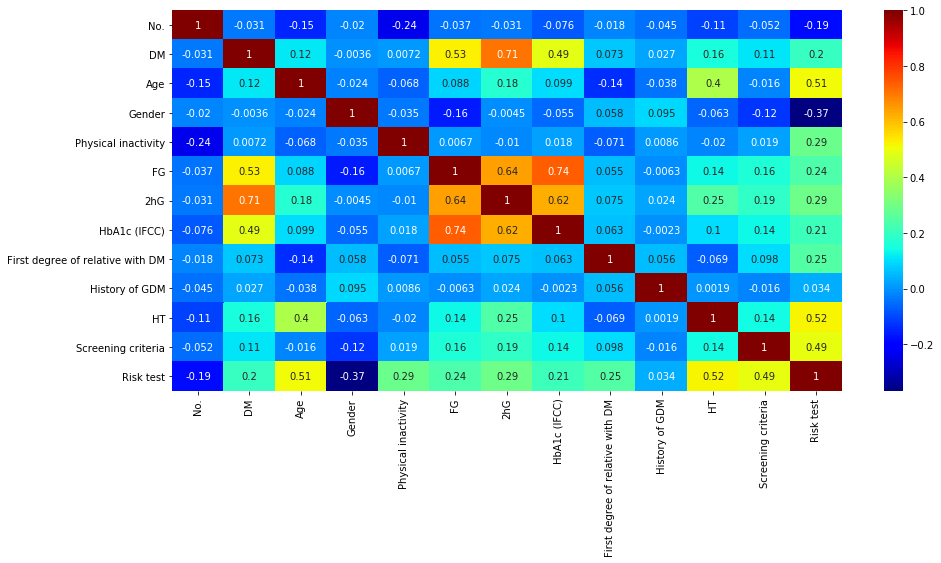

In [0]:
#----------[2-2:属性間の相関を可視化]-------------------
#
# 相関係数(r)を可視化 
#
#-----------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

df_corr=sheet_df.corr()
print(df_corr)
plt.figure(figsize=(15,7),facecolor="w")
sns.heatmap(df_corr,annot=True, cmap="jet")
plt.yticks(rotation=0)
plt.show()

---
#### 2-2の相関係数の分析図より、DM変数（糖尿病）と「FG,2hG,HbA1c」の3変数が正の相関が示唆される。Smoking4変数は文字列データの為に、相関分析に入っていない点に注意する。 簡便の為、デモでは**Age～HbA1cの7変数を入力変数として使う事にする**。
---

In [0]:
#------[2-3:出力を設定、入力を一部列から設定]---------------------------------------------
#
# 2列目の糖尿病(DM)を出力yとして抽出。
# 3列目～9列目の7変数を、入力Xとして抽出。(Age,Gender,smoking4,Physical inactivity,FG,2hG,hbA1c)
#--------------------------------------------------------------------------------

X=sheet_df.iloc[:, 2:9]
y=sheet_df.iloc[:,1]

#--------------------------
print('入力Xの変数確認')
X.head(10)


入力Xの変数確認


,Age,Gender,smoking4,Physical inactivity,FG,2hG,HbA1c (IFCC)
0,62,1,Never,0,5.8,11.7,45.359
1,51,1,Never,1,4.3,4.9,36.615
2,68,1,Never,1,8.0,18.8,55.196
3,47,1,Never,0,4.5,11.3,38.801
4,59,1,Never,1,4.8,7.9,40.987
5,62,1,Never,0,4.4,5.6,39.894
6,56,1,Never,0,4.2,5.8,36.615
7,48,1,Never,1,4.5,8.1,43.173
8,61,1,Never,0,5.5,11.0,43.173
9,58,1,Never,1,4.8,4.9,32.243


In [0]:
#--------ライブラリインストール----------

!pip install category_encoders

In [0]:
#------[2-4:カテゴリ変数をOne-hot-encodingへ(新規3列へ)]---------------------------------------------
#
#  smoking4がカテゴリ変数のため、One-hot-encodingを適用(smoking4=>Current,Former,Never)
#
#----------------------------------------------------------------------------------
import category_encoders as ce

list_cols = ['smoking4']
ce_ohe = ce.OneHotEncoder(cols=list_cols,handle_unknown='impute')
X2 = ce_ohe.fit_transform(X)
X2.head(10)


,Age,Gender,smoking4_1,smoking4_2,smoking4_3,Physical inactivity,FG,2hG,HbA1c (IFCC)
0,62,1,1,0,0,0,5.8,11.7,45.359
1,51,1,1,0,0,1,4.3,4.9,36.615
2,68,1,1,0,0,1,8.0,18.8,55.196
3,47,1,1,0,0,0,4.5,11.3,38.801
4,59,1,1,0,0,1,4.8,7.9,40.987
5,62,1,1,0,0,0,4.4,5.6,39.894
6,56,1,1,0,0,0,4.2,5.8,36.615
7,48,1,1,0,0,1,4.5,8.1,43.173
8,61,1,1,0,0,0,5.5,11.0,43.173
9,58,1,1,0,0,1,4.8,4.9,32.243


<Figure size 432x288 with 0 Axes>

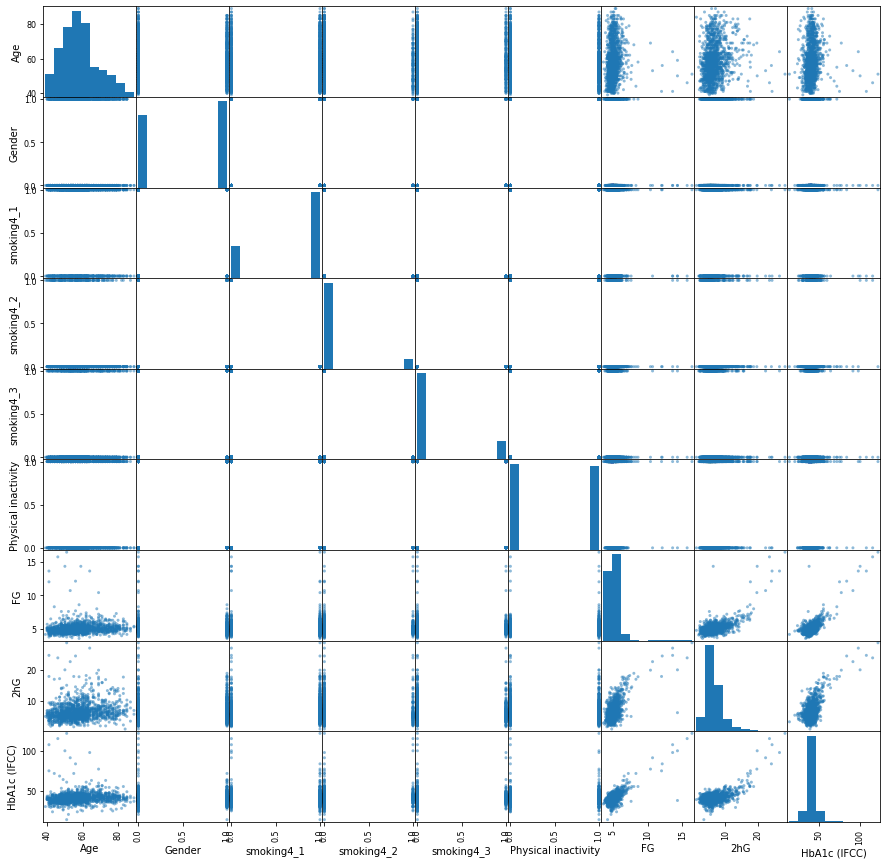

In [0]:
#----------[2-5:属性変数の分布を可視化]--------------------------------------
#
# 対角線上のグラフが、各属性の分布
# 属性変数は、定量変数（数値）と定性変数（カテゴリ）が混じっている事に注意
#
#--------------------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.figure(facecolor='w')
pd.plotting.scatter_matrix(X2, figsize=(15,15))
plt.show()

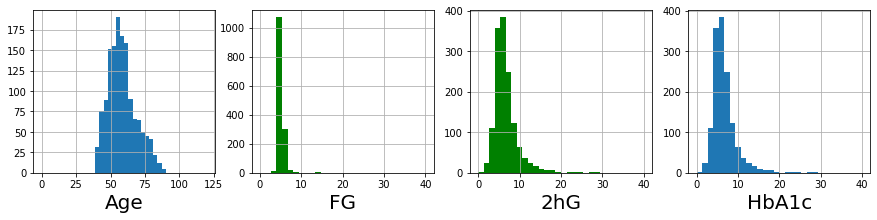

In [0]:
#---[2-6: 4変数のみ、ヒストグラムで分布を確認]-----------------------------

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 3));

ax1 = fig.add_subplot(1, 4, 1)  
xtmp=X.iloc[:,0] 
ax1.hist(xtmp, range=(0, 120),bins=40)
ax1.grid(True)     
plt.xlabel('Age',fontsize=20)


ax2 = fig.add_subplot(1, 4, 2)  
xtmp=X.iloc[:,4] 
ax2.hist(xtmp, color='green', range=(0, 40),bins=30)
ax2.grid(True)     
plt.xlabel('FG',fontsize=20)

ax3 = fig.add_subplot(1, 4, 3)  
xtmp=X.iloc[:,5] 
ax3.hist(xtmp, color='green', range=(0, 40),bins=30)
ax3.grid(True)    
plt.xlabel("2hG", fontsize=20)   


ax4 = fig.add_subplot(1, 4, 4)  
xtmp=X.iloc[:,5] 
ax4.hist(xtmp, range=(0, 40),bins=30, label="HbA1c")
ax4.grid(True)     
plt.xlabel("HbA1c", fontsize=20)    
fig.show()



---
---
### [3]. XGBoostによる糖尿病予測、変数重要度、木構造可視化

- XGBoostは勾配ブースティング決定木 (Gradient Boosting Decision Tree) のアルゴリズムを使った機械学習モデルです。
- サンプルを「訓練」＋「テスト」に分割

In [0]:
#---------[3-1: 患者(＝ROW)を、訓練データとテストデータに分割]----------------------------
#　
# 1,415人の患者を、訓練データ(8割)とテストデータ(2割)に分割 
#
# yの糖尿病患者(1)の数が少ないので、均等割のstratifyフラグを付けた
#-------------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split

#---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X2,y, test_size=0.20,stratify=y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 2}
[Accuracy: 1.00000]


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished


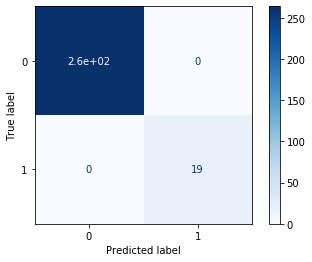

In [0]:
#---------[3-2: XGBoostによる糖尿病予測]----------------------------
#　
#  XGBoostによるモデル学習
#  Accuracyによる評価尺度値は98.9%
#  混同行列の表示。
#
#-------------------------------------------------------------------------------------

import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix


#---------学習-------------------------------

reg = xgb.XGBClassifier()
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6]},verbose=1) # ハイパーパラメータ探索(木構造の深さ)
reg_cv.fit(X_train, y_train)
print(reg_cv.best_params_)
#print(reg_cv.best_score_)

model_xgb = xgb.XGBClassifier(**reg_cv.best_params_)
model_xgb.fit(X_train, y_train)

#---------予測と評価(Accuracy)-------------------------------

y_pred = model_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('[Accuracy: %.5f]' % acc)

#---------混同行列----------------------
plot_confusion_matrix(model_xgb, X_test, y_test, cmap=plt.cm.Blues)

In [0]:
#---------[3-3: 属性(変数)重要度]----------------------------
#　
#  [1] 2hG:ブドウ糖負荷試験の2時間後血糖値 　
#  [2] FG : 空腹時血糖値 
#  [3] Age: 年齢  
#  [4] HbA1c : ヘモグロビンA1c 
#
#---------------------------------------------------------
fti = model_xgb.feature_importances_   

print('Feature Importances:')
for i, feat in enumerate(X2.columns.values):
    print('\t{0:20s} : {1:>.4f}'.format(feat, fti[i]))

Feature Importances:
	Age                  : 0.0098
	Gender               : 0.0000
	smoking4_1           : 0.0000
	smoking4_2           : 0.0000
	smoking4_3           : 0.0000
	Physical inactivity  : 0.0000
	FG                   : 0.0687
	2hG                  : 0.9215
	HbA1c (IFCC)         : 0.0000


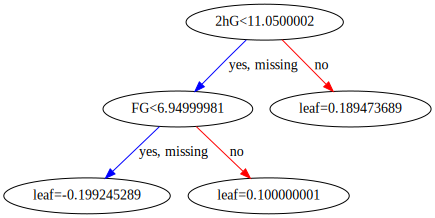

In [0]:
#---------[3-4: 木構造分類による可視化]------------------------------------------
#
# XGBoostは、決定木アルゴリズム（Gradient Boosting Decision Tree）のため、
# 学習した木構造を可視化できる。
#
#----------------------------------------------------------
# 結果の木構造の解釈
#
# (1)2hG値が11.1より大きいと糖尿病に分類
#             yes(DM=0)、no(DM=1)          
# (2)2hG値が小さくても、FG値（空腹時血糖値）が6.8より大きいと糖尿病に分類
#             yes(DM=0)、no(DM=1)  
#-----------------------------------------------------------------------------

xgb.to_graphviz(model_xgb)

-----
-----
-----
